In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, RocCurveDisplay

In [ ]:
def load_csv(path):
    for enc in ("utf-8", "euc-kr", "cp949"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            continue
    raise ValueError

train_df = load_csv("./data2/train.csv")
test_df = load_csv("./data2/test.csv")

LogReg: mean AUC 0.8436
GBoost: mean AUC 0.8804
Best model: GBoost
OOF AUC: 0.8803943906306335


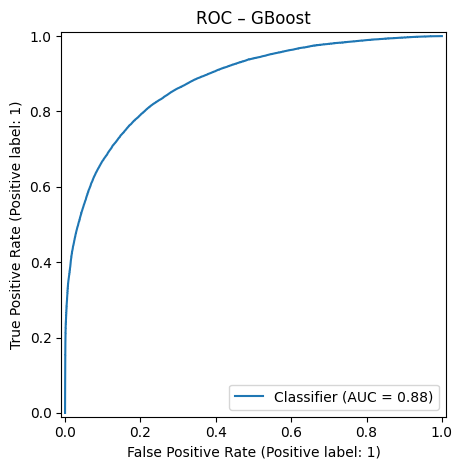

OSError: Cannot save file into a non-existent directory: '\mnt\data'

In [ ]:

for df in (train_df, test_df):
    df["일시"] = pd.to_datetime(df["일시"])
    df["hour"] = df["일시"].dt.hour
    df["dow"] = df["일시"].dt.dayofweek
    df["month"] = df["일시"].dt.month
    df.drop(columns=["일시"], inplace=True)

TARGET="공기질"
train_df=train_df.dropna(subset=[TARGET])
y=train_df[TARGET].astype(int)
X=train_df.drop(columns=[TARGET])
X_test=test_df.drop(columns=[TARGET], errors="ignore")

cat_cols=[c for c in ["역명_호선","주중주말"] if c in X.columns]
num_cols=[c for c in X.columns if c not in cat_cols]

from sklearn.pipeline import make_pipeline
num_pipe=make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
cat_pipe=make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))

preproc=ColumnTransformer([("num",num_pipe,num_cols), ("cat",cat_pipe,cat_cols)])

models={
    "LogReg": LogisticRegression(max_iter=500),
    "GBoost": GradientBoostingClassifier(random_state=42)
}

cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results={}
for name, clf in models.items():
    pipe=Pipeline([("prep",preproc), ("clf",clf)])
    aucs=cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc")
    results[name]=aucs
    print(f"{name}: mean AUC {aucs.mean():.4f}")

best=max(results, key=lambda k: results[k].mean())
print("Best model:", best)
best_pipe=Pipeline([("prep",preproc), ("clf",models[best])])
y_oof=cross_val_predict(best_pipe, X, y, cv=cv, method="predict_proba")[:,1]
print("OOF AUC:", roc_auc_score(y, y_oof))
RocCurveDisplay.from_predictions(y, y_oof)
plt.title(f"ROC – {best}")
plt.tight_layout()
plt.show()
best_pipe.fit(X, y)
test_proba=best_pipe.predict_proba(X_test)[:,1]
pred_df=pd.DataFrame({"air_quality_proba":test_proba})
out_path="./data2/test_air_quality_pred.csv"
pred_df.to_csv(out_path, index=False)
print("Predictions saved to", out_path)


In [5]:
from sklearn.metrics import roc_auc_score

# best_pipe 는 이미 train 전체로 학습한 파이프라인
y_test  = test["공기질"].astype(int)
X_test  = test.drop(columns=["공기질"])

y_prob  = best_pipe.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test, y_prob)
print(f"테스트 세트 AUC-ROC: {test_auc:.4f}")


NameError: name 'test' is not defined

In [6]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import warnings, os, json, textwrap

warnings.filterwarnings("ignore")


In [8]:

# ---------- 1. Load CSV with encoding fallback -----------------
def load_csv(path):
    for enc in ("utf-8", "euc-kr", "cp949"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            continue
    raise ValueError(f"Cannot read {path}")

train_path = "./data2/train.csv"
test_path  = "./data2/test.csv"

train_df = load_csv(train_path)
test_df  = load_csv(test_path)


In [10]:
train_df[TARGET].value_counts(dropna=False)

공기질
0.0    44577
1.0    35253
NaN     7770
Name: count, dtype: int64

In [9]:

# ---------- 2. Feature engineering (일시 파싱) ------------------
for df in (train_df, test_df):
    df["일시"] = pd.to_datetime(df["일시"])
    df["hour"]  = df["일시"].dt.hour
    df["dow"]   = df["일시"].dt.dayofweek
    df["month"] = df["일시"].dt.month
    df.drop(columns=["일시"], inplace=True)

TARGET = "공기질"
assert TARGET in train_df.columns and TARGET in test_df.columns, "라벨이 없습니다."

X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET].astype(int)

X_test  = test_df.drop(columns=[TARGET])
y_test  = test_df[TARGET].astype(int)

categorical_cols = [c for c in ["역명_호선", "주중주말"] if c in X_train.columns]
numeric_cols     = [c for c in X_train.columns if c not in categorical_cols]

num_pipe = make_pipeline(SimpleImputer(strategy="median"),
                         StandardScaler())
cat_pipe = make_pipeline(SimpleImputer(strategy="most_frequent"),
                         OneHotEncoder(handle_unknown="ignore"))

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_cols),
        ("cat", cat_pipe, categorical_cols)
    ]
)


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:

# ---------- 3. Candidate models --------------------------------
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "GradientBoosting"  : GradientBoostingClassifier(random_state=42),
    "RandomForest"      : RandomForestClassifier(
                              n_estimators=400, max_depth=None,
                              n_jobs=-1, random_state=42)
}

# Try XGBoost if available
try:
    from xgboost import XGBClassifier
    models["XGBoost"] = XGBClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="auc",
        n_jobs=-1,
        random_state=42
    )
except ImportError:
    pass  # skip if not installed


In [ ]:

# ---------- 4. Fit & evaluate -----------------------------------
results = {}
for name, clf in models.items():
    pipe = Pipeline([
        ("prep", preprocess),
        ("model", clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    results[name] = {"auc": auc, "pipeline": pipe}


In [ ]:

# ---------- 5. Show results -------------------------------------
print("=== Test‑set ROC‑AUC ===")
for k,v in results.items():
    print(f"{k:18s}: {v['auc']:.4f}")

best_name = max(results, key=lambda k: results[k]["auc"])
best_auc  = results[best_name]["auc"]
best_pipe = results[best_name]["pipeline"]

print(f"\n► Best model on test set: {best_name}  (AUC={best_auc:.4f})")


In [ ]:

# ---------- 6. Plot ROC curve for the best model ---------------
RocCurveDisplay.from_estimator(best_pipe, X_test, y_test)
plt.title(f"ROC Curve – {best_name}")
plt.tight_layout()
plt.show()


In [ ]:

# Optional: save test predictions
pred_df = pd.DataFrame({
    "air_quality_proba": best_pipe.predict_proba(X_test)[:,1],
    "actual_label": y_test.values
})
out_path = "/mnt/data/test_air_quality_with_pred.csv"
pred_df.to_csv(out_path, index=False)
print(f"\nDetailed predictions saved → {out_path}")


# 모델

In [12]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder     # 문자열 라벨일 때만 필요

TARGET = "공기질"

# 1. 데이터 불러오기 ----------------------------------------------------------
train = pd.read_csv("./data2/train.csv", encoding="utf-8")
test  = pd.read_csv("./data2/test.csv",  encoding="utf-8")

# 2. 날짜 파생변수(예시) -------------------------------------------------------
for df in (train, test):
    df["일시"] = pd.to_datetime(df["일시"])
    df["hour"]  = df["일시"].dt.hour
    df["dow"]   = df["일시"].dt.dayofweek
    df["month"] = df["일시"].dt.month
    df.drop(columns=["일시"], inplace=True)

# 3. 라벨 결측 분리 ------------------------------------------------------------
#   ├─ train_clean : 학습용  (라벨 O)
#   ├─ test_eval   : 평가용  (라벨 O)
#   └─ test_pred   : 제출용  (라벨 X)
train_clean = train.dropna(subset=[TARGET]).copy()
test_eval   = test .dropna(subset=[TARGET]).copy()
test_pred   = test [ test[TARGET].isna() ].copy()

# 4. (문자열 라벨이라면) 숫자 인코딩 ------------------------------------------
if train_clean[TARGET].dtype == "object":
    le = LabelEncoder()
    le.fit(pd.concat([train_clean[TARGET], test_eval[TARGET]]))
    train_clean[TARGET] = le.transform(train_clean[TARGET])
    test_eval[TARGET]   = le.transform(test_eval[TARGET])

# 5. 정수 캐스팅 → 오류 사라짐 -------------------------------------------------
y_train = train_clean[TARGET].astype(int)
y_test  = test_eval[TARGET].astype(int)
X_train = train_clean.drop(columns=[TARGET])
X_test  = test_eval.drop(columns=[TARGET])

LogReg   Test-AUC = 0.7832
GBoost   Test-AUC = 0.8076

► Test 세트 기준 최고 모델: GBoost  (AUC = 0.8076)


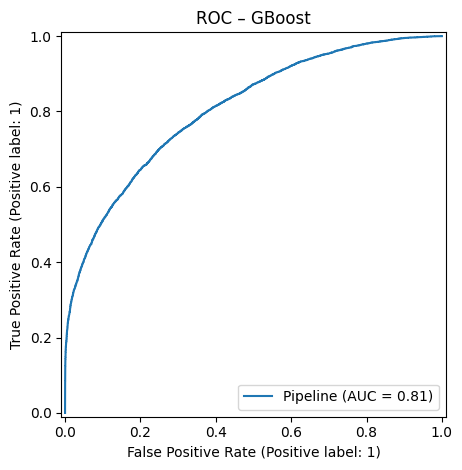

제출용(라벨-없음) 행이 없습니다.


In [13]:
# ---------------------------------------------------------------------
# 0) 공통 라이브러리
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.compose        import ColumnTransformer
from sklearn.pipeline       import Pipeline, make_pipeline
from sklearn.preprocessing  import OneHotEncoder, StandardScaler
from sklearn.impute         import SimpleImputer
from sklearn.metrics        import roc_auc_score, RocCurveDisplay
from sklearn.linear_model   import LogisticRegression
from sklearn.ensemble       import GradientBoostingClassifier
# 필요하면 RandomForest / XGBoost 등 추가

# ---------------------------------------------------------------------
# 1) 특징/라벨 분리  (앞 단계에서 이미 NaN 라벨 제거 및 인코딩 완료)
TARGET = "공기질"
X_train, y_train = train_clean.drop(columns=[TARGET]), train_clean[TARGET].astype(int)
X_eval , y_eval  = test_eval .drop(columns=[TARGET]), test_eval [TARGET].astype(int)

# ---------------------------------------------------------------------
# 2) 전처리 파이프라인
cat_cols = [c for c in ["역명_호선", "주중주말"] if c in X_train.columns]
num_cols = [c for c in X_train.columns if c not in cat_cols]

num_pipe = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
cat_pipe = make_pipeline(SimpleImputer(strategy="most_frequent"),
                         OneHotEncoder(handle_unknown="ignore"))
preproc  = ColumnTransformer([("num", num_pipe, num_cols),
                              ("cat", cat_pipe, cat_cols)])

# ---------------------------------------------------------------------
# 3) 여러 모델 중 성능 비교
models = {
    "LogReg":  LogisticRegression(max_iter=1000, n_jobs=-1),
    "GBoost":  GradientBoostingClassifier(random_state=42),
    # "RF":    RandomForestClassifier(...),
    # "XGB":   XGBClassifier(...),
}

results = {}
for name, clf in models.items():
    pipe = Pipeline([("prep", preproc), ("model", clf)])
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_eval)[:, 1]
    auc   = roc_auc_score(y_eval, proba)
    results[name] = {"auc": auc, "pipe": pipe}
    print(f"{name:7s}  Test-AUC = {auc:.4f}")

best   = max(results, key=lambda k: results[k]["auc"])
best_auc  = results[best]["auc"]
best_pipe = results[best]["pipe"]
print(f"\n► Test 세트 기준 최고 모델: {best}  (AUC = {best_auc:.4f})")

# ---------------------------------------------------------------------
# 4) ROC 곡선 시각화 (선택)
RocCurveDisplay.from_estimator(best_pipe, X_eval, y_eval)
plt.title(f"ROC – {best}")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 5) 라벨 없는 test_pred 행들에 대해 확률 예측 → 제출 파일 저장
if not test_pred.empty:
    X_submit = test_pred.drop(columns=[TARGET], errors="ignore")
    submit_proba = best_pipe.predict_proba(X_submit)[:, 1]
    out = test_pred[["id"]] if "id" in test_pred.columns else pd.DataFrame(index=test_pred.index)
    out["air_quality_proba"] = submit_proba
    out.to_csv("test_pred_air_quality.csv", index=False)
    print("✅  test_pred_air_quality.csv 파일 생성 완료")
else:
    print("제출용(라벨-없음) 행이 없습니다.")


# semi-supervised

In [15]:
# air_quality_full_pipeline.py
import pandas as pd, numpy as np, warnings, joblib
from pathlib import Path
from sklearn.compose      import ColumnTransformer
from sklearn.pipeline     import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute        import SimpleImputer, KNNImputer
from sklearn.linear_model  import LogisticRegression
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics       import roc_auc_score, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.utils         import Bunch

warnings.filterwarnings("ignore")
DATA_PATH = Path("./data2/")              # <<-- 경로 수정


In [16]:

# ------------------------------------------------------------------ #
# 1. 데이터 로딩 & 날짜 파생
def read_csv_auto(path):
    for enc in ("utf-8","euc-kr","cp949"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception: pass
    raise ValueError(f"인코딩 불가: {path}")

train = read_csv_auto(DATA_PATH/"train.csv")
test  = read_csv_auto(DATA_PATH/"test.csv")

for df in (train, test):
    df["일시"]  = pd.to_datetime(df["일시"])
    df["hour"]  = df["일시"].dt.hour
    df["month"] = df["일시"].dt.month
    df["dow"]   = df["일시"].dt.dayofweek
    df.drop(columns=["일시"], inplace=True)

TARGET = "공기질"


In [17]:

# ------------------------------------------------------------------ #
# 2. 데이터 분할 (라벨 O / 라벨 X)
train_labeled   = train.dropna(subset=[TARGET]).copy()
train_unlabeled = train[ train[TARGET].isna() ].copy()
test_labeled    = test .dropna(subset=[TARGET]).copy()
test_unlabeled  = test [ test [TARGET].isna() ].copy()

y_train = train_labeled[TARGET].astype(int)
X_train = train_labeled.drop(columns=[TARGET])

y_test  = test_labeled [TARGET].astype(int)
X_test  = test_labeled .drop(columns=[TARGET])


In [18]:

# ------------------------------------------------------------------ #
# 3. 공통 전처리: 범주/수치 구분 + 2단계 결측 보간
cat_cols = [c for c in ["역명_호선","주중주말"] if c in X_train.columns]
num_cols = [c for c in X_train.columns if c not in cat_cols]


In [19]:

# 단계 ① 시간·월·역별 중앙값
class GroupMedianImputer:
    def __init__(self, group_cols, num_cols):
        self.group_cols, self.num_cols = group_cols, num_cols
    def fit(self, X, y=None):
        self.med_ = (
            X[self.group_cols + self.num_cols]
            .groupby(self.group_cols)
            .median()
            .reset_index()
        )
        return self
    def transform(self, X):
        X = X.copy()
        X = X.merge(self.med_, on=self.group_cols, how="left", suffixes=("","_grp"))
        for c in self.num_cols:
            X[c] = X[c].fillna(X[f"{c}_grp"])
            X.drop(columns=[f"{c}_grp"], inplace=True)
        return X

group_imputer = GroupMedianImputer(group_cols=["hour","month","역명_호선"],
                                   num_cols=num_cols)


In [20]:

# 단계 ② KNN Imputer (잔여 결측)
num_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
    KNNImputer(n_neighbors=5)
)
cat_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preproc = ColumnTransformer(
    [("num", num_pipe, num_cols),
     ("cat", cat_pipe, cat_cols)]
)


In [22]:

# ------------------------------------------------------------------ #
# 4. 관측확률 p_obs 모델 (로지스틱)
pobs_feats = ["hour","month","dow"] + cat_cols
pobs_pipe  = Pipeline([
    ("grp_impute", group_imputer),
    ("prep", ColumnTransformer([
         ("num", make_pipeline(SimpleImputer(strategy="median"),
                               StandardScaler()),
          ["hour","month","dow"]),
         ("cat", cat_pipe, cat_cols)
    ])),
    ("clf", LogisticRegression(max_iter=500))
])


In [24]:
# ---------------------------------- p_obs 모델 수정 -------------------------
pobs_cols = ["hour", "month", "dow", "역명_호선", "주중주말"]  # 최소 피처만
pobs_X = pd.concat([train_labeled[pobs_cols], train_unlabeled[pobs_cols]])
pobs_y = pd.concat([train_labeled["is_obs"],  train_unlabeled["is_obs"]])

pobs_pipe = Pipeline([
    ("prep", ColumnTransformer([
        ("num", make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
         ["hour","month","dow"]),
        ("cat", cat_pipe, ["역명_호선","주중주말"])
    ])),
    ("clf", LogisticRegression(max_iter=500))
])
pobs_pipe.fit(pobs_X, pobs_y)

train_labeled["p_obs"] = pobs_pipe.predict_proba(train_labeled[pobs_cols])[:,1]
train_labeled["w"]     = 1 / train_labeled["p_obs"].clip(lower=0.05)

In [25]:

train_labeled["is_obs"] = 1
train_unlabeled["is_obs"] = 0
pobs_X = pd.concat([train_labeled[pobs_feats], train_unlabeled[pobs_feats]])
pobs_y = pd.concat([train_labeled["is_obs"],  train_unlabeled["is_obs"]])
pobs_pipe.fit(pobs_X, pobs_y)
train_labeled["p_obs"] = pobs_pipe.predict_proba(train_labeled[pobs_feats])[:,1]
# 안전 차원 클리핑
train_labeled["w"] = 1 / train_labeled["p_obs"].clip(lower=0.05)


In [27]:

# ------------------------------------------------------------------ #
# 5. Self-Training 기반 실제 모델
base_clf = GradientBoostingClassifier(random_state=42)
self_clf = SelfTrainingClassifier(
    base_clf,
    threshold=0.9,             # 0.9↑ / 0.1↓ 만 pseudo-label
    verbose=True
)

full_pipe = Pipeline([
    ("grp_impute", group_imputer),
    ("prep", preproc),
    ("clf", self_clf)
])

# 라벨 있는 데이터 + 가중치 학습
full_pipe.fit(X_train, y_train, clf__sample_weight=train_labeled["w"])


ValueError: Grouper for 'hour' not 1-dimensional

In [ ]:

# ------------------------------------------------------------------ #
# 6. 평가 (AUC) – 시간×월×역 Stratified K-Fold
groups  = (X_train["hour"]//2).astype(str) + "_" + X_train["month"].astype(str) \
          + "_" + X_train["역명_호선"].astype(str)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
for tr_idx, va_idx in cv.split(X_train, y_train, groups):
    full_pipe.fit(X_train.iloc[tr_idx], y_train.iloc[tr_idx],
                  clf__sample_weight=train_labeled.iloc[tr_idx]["w"])
    proba = full_pipe.predict_proba(X_train.iloc[va_idx])[:,1]
    auc_scores.append( roc_auc_score(y_train.iloc[va_idx], proba) )
print(f"CV AUC  : {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

# ------------------------------------------------------------------ #
# 7. 테스트 AUC
test_proba = full_pipe.predict_proba(X_test)[:,1]
test_auc   = roc_auc_score(y_test, test_proba)
print(f"Test AUC: {test_auc:.4f}")

# ------------------------------------------------------------------ #
# 8. 라벨 없는 행 예측 & 저장
if not test_unlabeled.empty:
    unlabeled_proba = full_pipe.predict_proba(test_unlabeled.drop(columns=[TARGET]))[:,1]
    sub = test_unlabeled[["id"]] if "id" in test_unlabeled.columns else pd.DataFrame(index=test_unlabeled.index)
    sub["air_quality_proba"] = unlabeled_proba
    sub.to_csv("test_unlabeled_pred.csv", index=False)
    print("✅  test_unlabeled_pred.csv 저장 완료")

# (선택) 전체 모델·p_obs 모델 저장
joblib.dump(full_pipe, "air_quality_model_full.pkl")
joblib.dump(pobs_pipe, "p_obs_model.pkl")
print("모델 두 개를 pkl로 저장했습니다.")
